Ngo Thi Minh Thu - PTDLk55

# KDE Classifier

In [42]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

# Load Data
dataset = load_iris()

In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.neighbors import KernelDensity

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) #Compute the log-likelihood of each sample under the model.
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return (result / result.sum(1, keepdims=True))
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [44]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(dataset.data, dataset.target)

scores = grid.cv_results_['mean_test_score']
#scores = [val.mean_validation_score for val in grid.cv_results_]

{'bandwidth': 0.31992671377973836}
accuracy = 0.9733333333333334


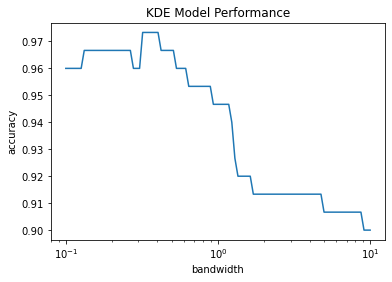

In [45]:
import matplotlib.pyplot as plt

plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

# Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), dataset.data, dataset.target).mean()

0.9533333333333334

<h1> Statistical Data Analysis and Probability </h1>

In [47]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import csv
weather = pd.read_csv('wa_weather_1944_till_2016.csv',
                      parse_dates=[['Year','Month','Day']],
                      index_col="Year_Month_Day").drop(['min_temp_C','max_temp_C','daily_avg','daily_range','uv_MJ_m*m'],axis=1)
weather.head()

,rainfall_mm
Year_Month_Day,
1944-05-01,0.0
1944-05-02,0.0
1944-05-03,0.0
1944-05-04,4.3
1944-05-05,0.0


array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

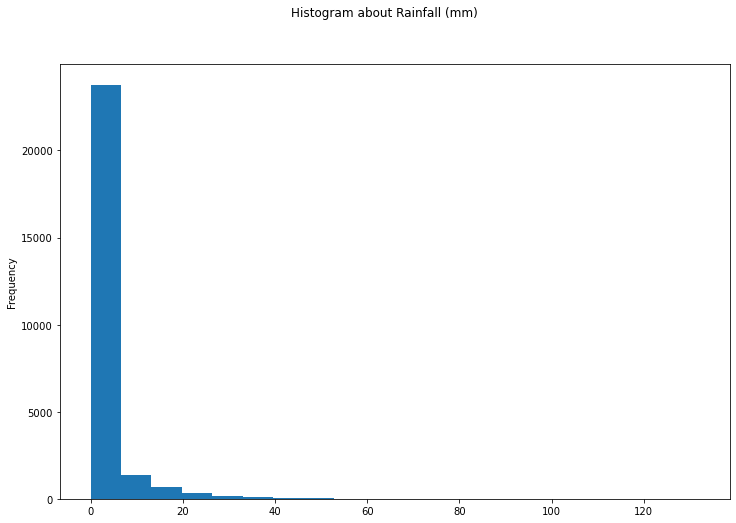

In [49]:
df = weather['rainfall_mm']
df.plot(kind='hist',subplots=True,figsize=(12,8),bins=20,title='Histogram about Rainfall (mm)')

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

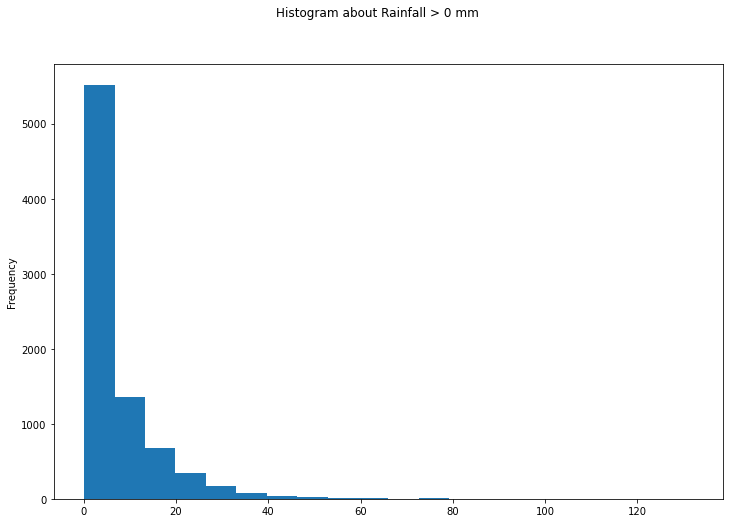

In [50]:
df_ppt = df[df>0]
df_ppt.plot(kind='hist',subplots=True,figsize=(12,8),bins=20,title='Histogram about Rainfall > 0 mm')

# Fitting data to the exponential distribution

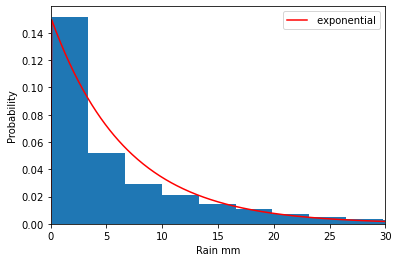

In [51]:
param_loc, param_scale = stats.expon.fit(df_ppt)
xx = np.arange(0,30,0.1)
y = stats.expon.pdf(xx, loc=param_loc, scale=param_scale)

plt.hist(df_ppt,density=True,bins=40)
plt.plot(xx,y, color='red',label=' exponential')
plt.xlim(0,30)
plt.xlabel('Rain mm')
plt.ylabel('Probability')
plt.legend(loc='upper right')

In [52]:
print(param_loc, param_scale)

0.1 6.685194647201946


In [53]:
def mean(data):
    n = len(data)
    mean = sum(data) / n
    return mean

In [54]:
mean(df_ppt)

6.785194647201846

In [55]:
df_ppt.mean()

6.785194647201846

In [56]:
def variance(data):   
    n = len(data) 
    mean = sum(data) / n
    deviations = [(x - mean) ** 2 for x in data]
    variance = sum(deviations) / n
    return variance

In [57]:
def stdev(data):
    import math
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

In [58]:
stdev(df_ppt)

8.875221036201385

In [59]:
df_ppt.std()

8.875760940757422

# Fitting aggregated counts to the Poisson distribution

In [60]:
rain = pd.read_csv('wa_weather_1944_till_2016.csv')
rain = rain[rain['Month']==12]
df = rain[rain['rainfall_mm']>0]
numofrainydays = df.groupby('Year').count()
num = np.asarray(numofrainydays['Day'])

In [61]:
from scipy.optimize import minimize

In [62]:
def log_likelihood(k, mu):
    return -stats.poisson.logpmf(k, mu).sum()

In [63]:
smean = num.mean()
days = np.linspace(0, 12, 13)
params = minimize(log_likelihood, x0=smean, args=(num,))

C:\Users\ADMIN\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


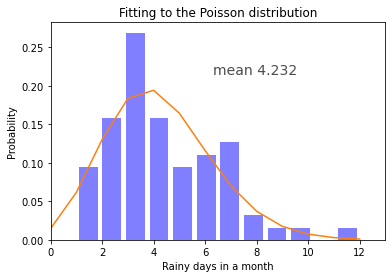

In [64]:
fig, ax = plt.subplots()
plt.title('Fitting to the Poisson distribution')

# Limiting the x-asis for a better plot
plt.xlim([0, 13])
plt.figtext(0.5, 0.7, 'mean {:.3f}'.format(smean), alpha=0.7,
                fontsize=14)
plt.xlabel('Rainy days in a month')
plt.ylabel('Probability')
ax.hist(num, density=True, label='Data',bins=12,rwidth=0.8,facecolor='blue', alpha=0.5)
ax.plot(days, stats.poisson.pmf(days, params.x))

# Fitting aggregated data to the gamma  distribution

In [65]:
weather = pd.read_csv('wa_weather_1944_till_2016.csv').drop(['min_temp_C','max_temp_C','daily_avg','daily_range','uv_MJ_m*m'],axis=1)

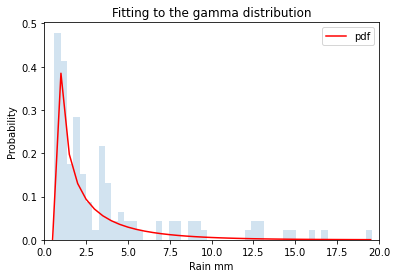

In [66]:
rain_Jan = weather[weather.Month==1]
rain_Jan = rain_Jan[rain_Jan['rainfall_mm']>0.5]
data = rain_Jan[rain_Jan['rainfall_mm']<20]['rainfall_mm']
#plt.hist(data,bins=200)
params = stats.gamma.fit(data)
xx = np.arange(0.5, 20, 0.5)
y = stats.gamma.pdf(xx,*params)

fig, ax = plt.subplots()
plt.title('Fitting to the gamma distribution')
plt.hist(data,bins=50,density=True, histtype='stepfilled',alpha=0.2)
plt.plot(xx,y, color='red', label='pdf')
plt.xlabel('Rain mm')
plt.ylabel('Probability')
plt.xlim(0,20)
plt.legend(loc='upper right')

# GEV

In [73]:
rain = pd.read_csv('wa_weather_1944_till_2016.csv').groupby(['Year'])['rainfall_mm'].max()

In [78]:
print(rain)

Year
1944    50.3
1945    78.2
1946    37.1
1947    78.0
1948    54.4
        ... 
2012    32.2
2013    42.6
2014    47.2
2015    40.0
2016    36.6
Name: rainfall_mm, Length: 73, dtype: float64


(array([ 7., 35., 17.,  7.,  2.,  2.,  2.,  0.,  0.,  1.]),
 array([ 23.6 ,  34.44,  45.28,  56.12,  66.96,  77.8 ,  88.64,  99.48,
        110.32, 121.16, 132.  ]),
 <BarContainer object of 10 artists>)

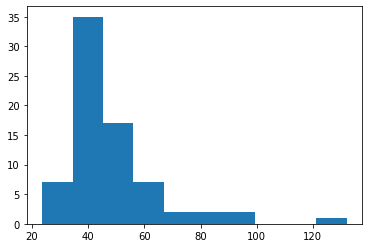

In [77]:
plt.hist(rain)

In [82]:
shape, loc, scale = gev.fit(rvs)
print(shape, loc, scale)

-0.14197175471785833 40.85693078397927 9.965619349222989


-0.14197175471785833
40.85693078397927
9.965619349222989


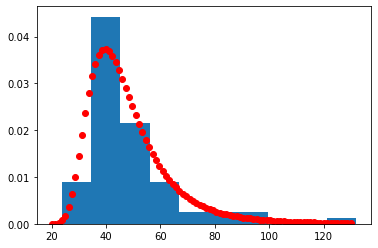

In [96]:
from scipy.stats import genextreme as gev
def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return shape, loc, scale

if __name__ == '__main__':
    rvs = rain

    shape, loc, scale = main(rvs)

    print(shape)
    print(loc)
    print(scale)

    xx = np.linspace(20, 130, num=90)
    yy = gev.pdf(xx, shape, loc, scale)

    plt.hist(rvs, density=True)
    plt.plot(xx, yy, 'ro')
    plt.show()